<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/1_Features_and_Target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [82]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read OHLC Data

In [84]:
ohlc = pd.read_parquet( root / '1. ohlc.parquet' )
ohlc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-10,57020.10,58029.98,56419.41,57648.71,57648.71,2.885763e+10
2024-09-11,57650.29,57991.32,55567.34,57343.17,57343.17,3.704906e+10
2024-09-12,57343.17,58534.36,57330.10,58127.01,58127.01,3.383571e+10
2024-09-13,58130.32,60648.02,57650.11,60571.30,60571.30,3.249053e+10
2024-09-14,60569.12,60656.72,59517.88,60005.12,60005.12,1.642841e+10


## Moving Averages

In [85]:
def simpleMA( metric, window ):
  return metric.rolling( window ).mean()

def expMA( metric, window ):
  return metric.ewm( span=window, min_periods=window ).mean()

In [86]:
price = ohlc['Close']

window = 30

MA = pd.DataFrame({
    f'ema({window})': expMA(price, window), })

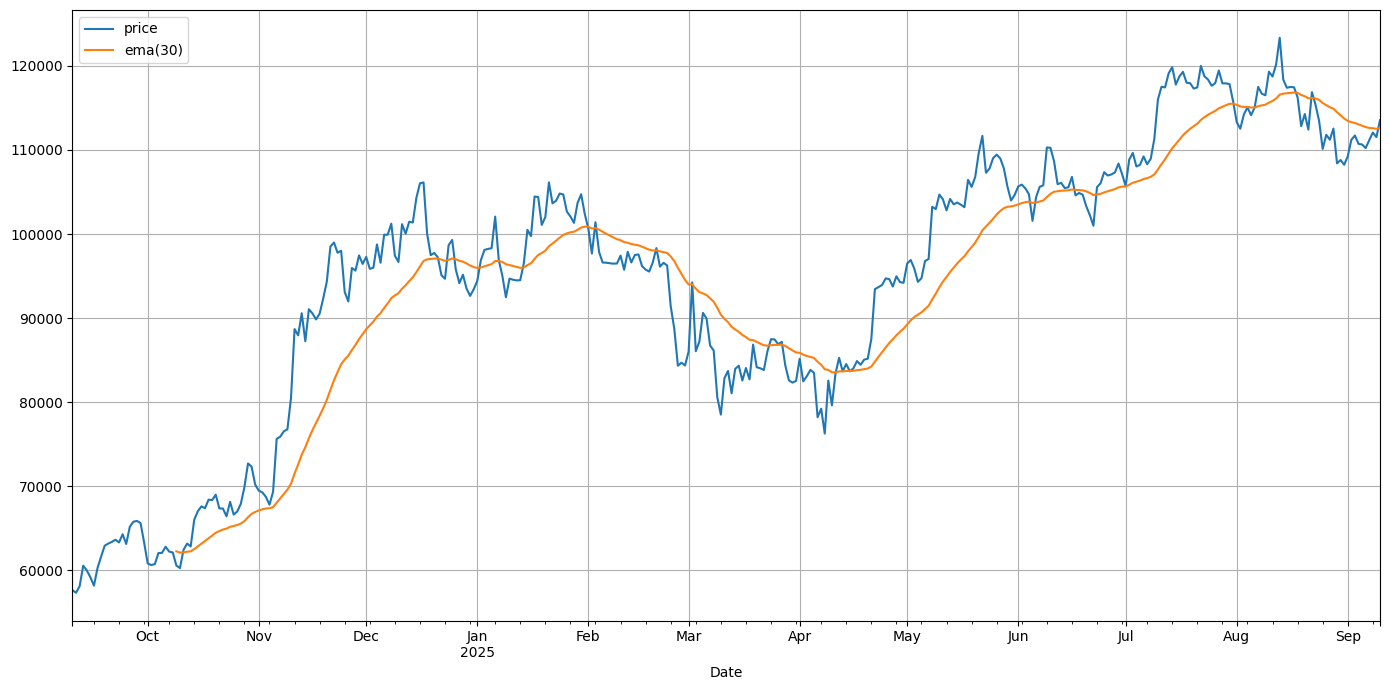

In [87]:
DF = pd.DataFrame({ 'price': price })
DF = pd.concat([ DF, MA ], axis=1 )
ax = DF.plot(figsize=(14, 7))
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Crossover

In [88]:
def crossover( s1, s2, lag ):
  x = s1 - s2
  x = x * 0 + np.sign(x)
  return x.shift(lag)

In [89]:
price = ohlc['Close']

short_window = 15
long_window =  50
lag = 1

short = simpleMA(price, short_window)
long  = simpleMA(price, long_window)
cross = crossover(short, long, lag)

Crossover = pd.DataFrame({
    f'x(sma({short_window}),sma({long_window}))': cross, })

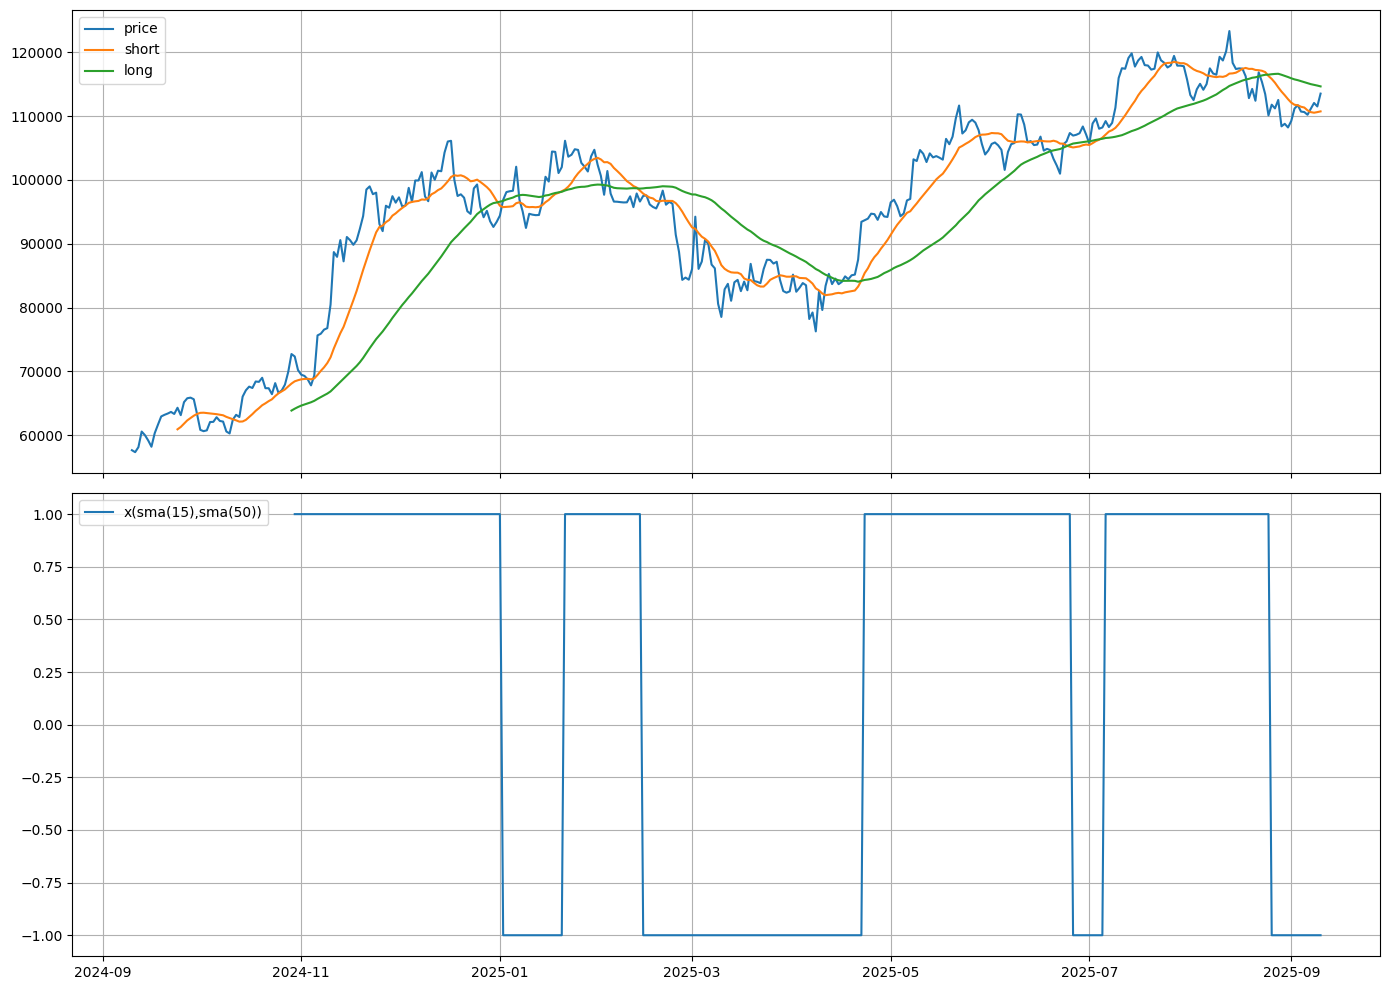

In [90]:
DF = pd.DataFrame({
    'price' : price,
    'short' : short,
    'long'  : long,
})
DF = pd.concat([ DF, Crossover ], axis=1 )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if not c.startswith('x') ]
bottom = [ c for c in DF.columns if c not in top ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in bottom:
  ax2.plot( DF[c], label=c )

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Bollinger Bands

In [91]:
def bollUpper( metric, window, stdevs ):
    return boll( metric, window, abs( stdevs ))

def bollLower( metric, window, stdevs ):
    return boll( metric, window, -abs( stdevs ))

def boll( metric, window, stdevs ):
    ma = simpleMA( metric, window )
    std = stDev( metric, window )
    return ma + ( std * stdevs )

def stDev( metric, window ):
    return metric.rolling( window ).std()

In [92]:
price = ohlc['Close']

window = 20
stdevs = 2

results = [
    bollUpper(price, window, stdevs),
    bollLower(price, window, stdevs), ]

names = [
    f'bollUpper({window},{stdevs})',
    f'bollLower({window},{stdevs})', ]

Bollinger = pd.DataFrame(dict(zip(names, results)))

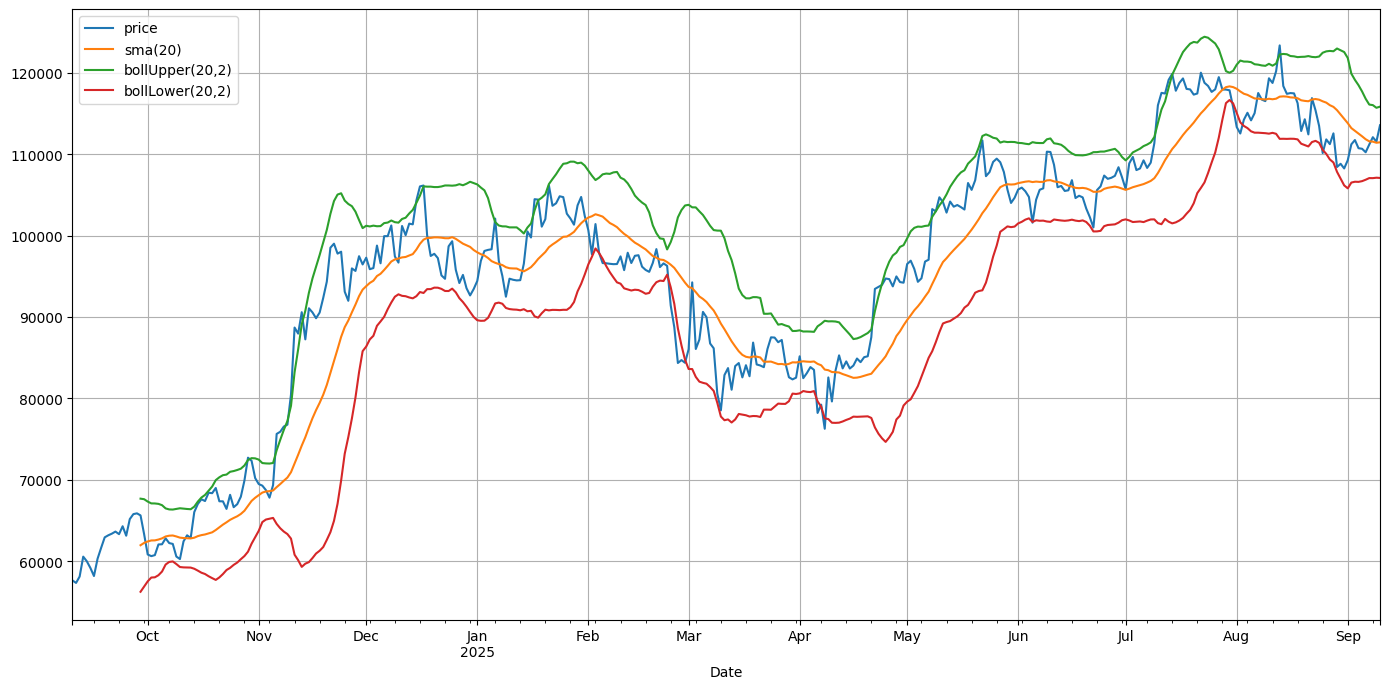

In [93]:
DF = pd.DataFrame({
    'price'          : price,
    f'sma({window})' : simpleMA(price, window),
})
DF = pd.concat([ DF, Bollinger ], axis=1 )
ax = DF.plot(figsize=(14, 7))
ax.grid(True)
plt.tight_layout()
plt.show()

### Moving Average Convergence Divergence (MACD)

Moving Average Convergence Divergence (MACD) involves the following three calculations; the last of which, the MACD distance, may be used by analysts in determining the magnitude of bullish or bearish momentum.

1. MACD is the difference between a long and short EMA.

2. The Signal Line is then the EMA of the MACD (#1).

3. The MACD Distance is the difference between the MACD (#1) and Signal Line (#2).

In [94]:
def macd(metric, short_window, long_window):
    short = expMA( metric, short_window )
    long = expMA( metric, long_window )
    return short - long

def macdDistance(macd_metric, signal_metric):
    return macd_metric - signal_metric

In [95]:
price = ohlc['Close']

short_window = 12
long_window = 26
signal_window = 9

short       = expMA( price, short_window )
long        = expMA( price, long_window )
macd_metric = macd( price, short_window, long_window )
signal      = expMA( macd_metric, signal_window )
macd_dist   = macdDistance( macd_metric, signal )

Macd = pd.DataFrame({
  f'macdDistance({short_window}, {long_window}, {signal_window})': macd_dist,
})

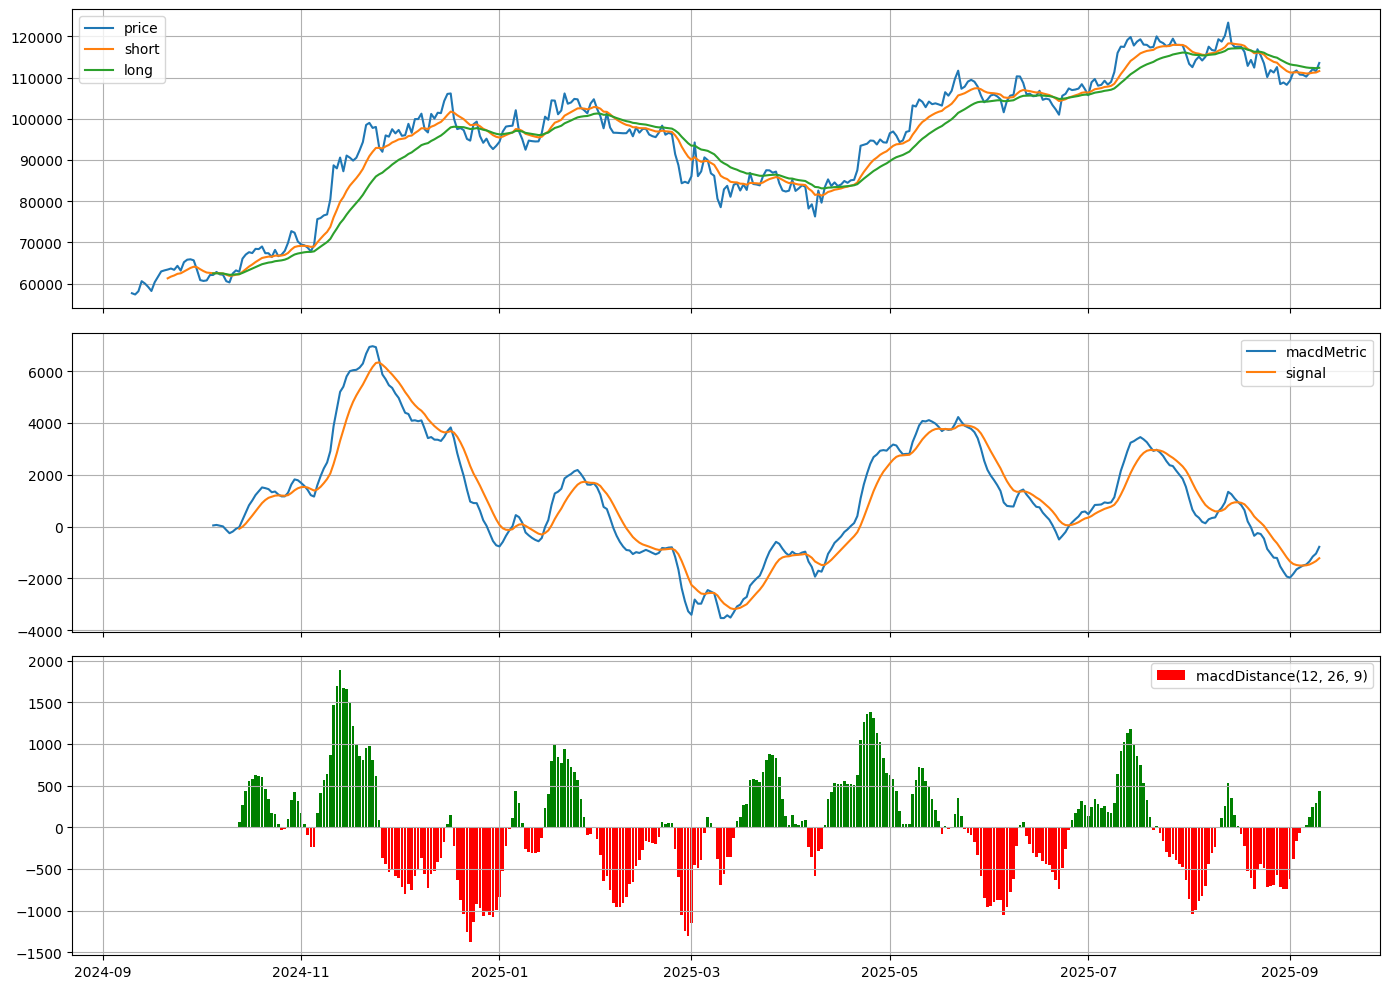

In [96]:
DF = pd.DataFrame({
    'price'     : price,
    'short'     : short,
    'macdMetric': macd_metric,
    'long'      : long,
    'signal'    : signal,
})
DF = pd.concat([ DF, Macd ], axis=1 )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if c.startswith(('price', 'short', 'long')) ]
middle = [ c for c in DF.columns if c.startswith(('macdMetric', 'signal')) ]
bottom = [ c for c in DF.columns if c.startswith(('macdDistance',)) ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in middle:
  ax2.plot( DF[c], label=c )


for c in bottom:
  series = DF[c]
  colors = ['green' if v > 0 else 'red' for v in series]
  ax3.bar(DF.index, series, label=c, color=colors)

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Oscillators

An oscillator is a trend indicator that fluctuates between an upper and a lower bound. Like Bollinger Bands, analysts use oscillators to help identify oversold and overbought signals.

Generally, an analyst might use a threshold above 70% or 80% to indicate an overbought asset, and a threshold below 30% or 20% to indicate an underbought asset.

### Stochastic Oscillator

In [97]:
def stochOscillator(metric, window):
    low = metric.rolling(window).min()
    high = metric.rolling(window).max()
    tmp = metric - low
    tmp /= high - low
    return tmp

In [98]:
price = ohlc['Close']

stoch_window = 14
sma_window = 3

stoch     = stochOscillator( price, stoch_window )
stock_sma = simpleMA( stoch, sma_window )

StochOscillator = pd.DataFrame({
    f'stoch({stoch_window})': stoch,
    f'stoch_sma({sma_window})': stock_sma,
})

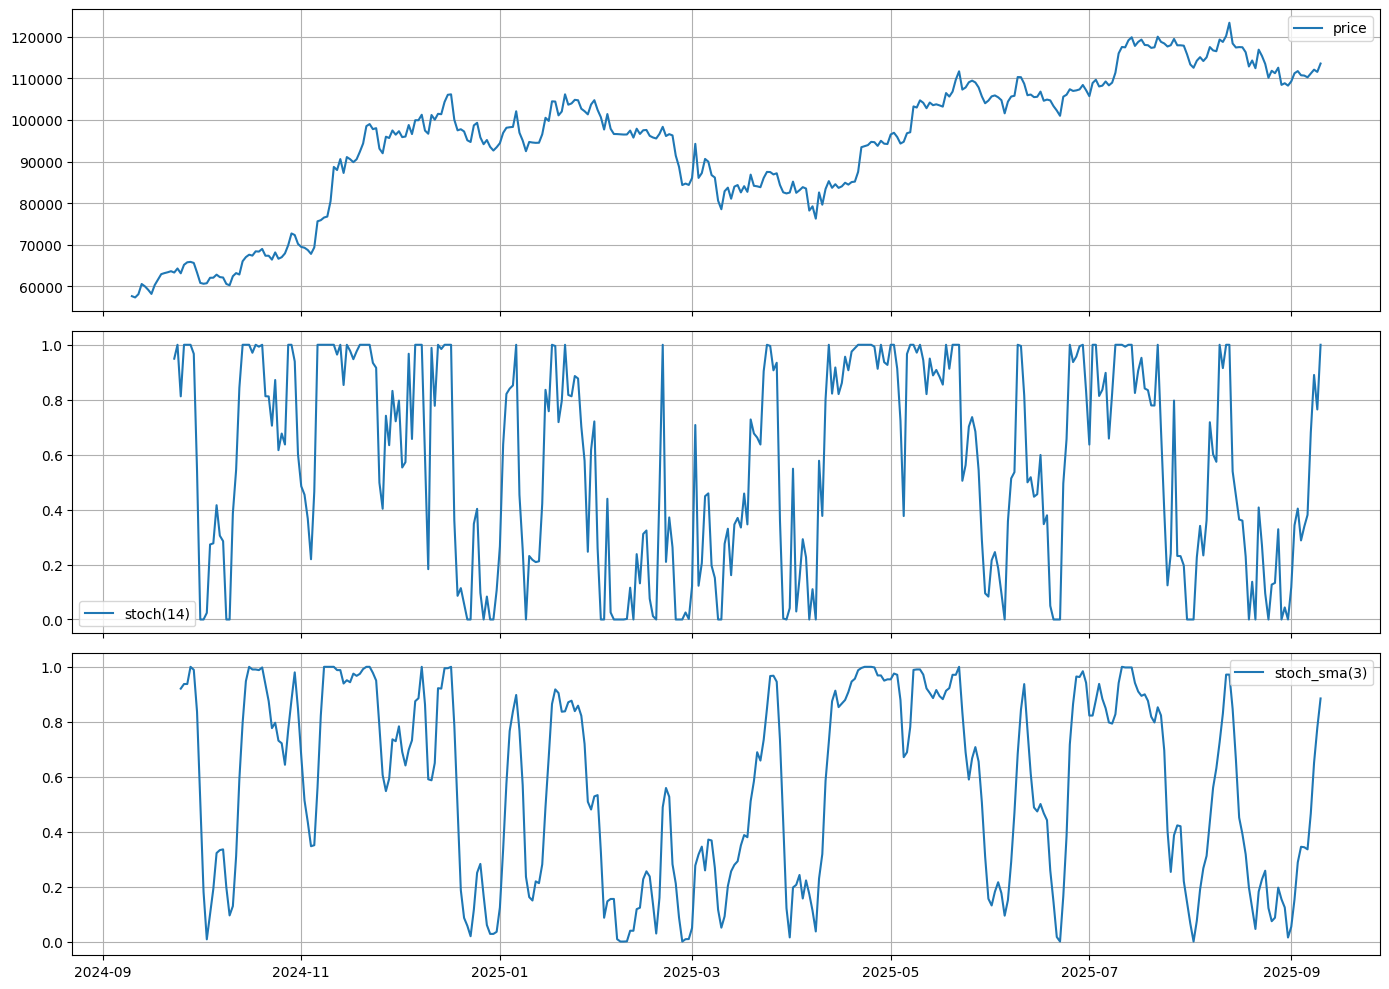

In [99]:
DF = pd.DataFrame({ 'price' : price, })
DF = pd.concat([ DF, StochOscillator ], axis=1 )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if c.startswith('price') ]
middle = [ c for c in DF.columns if c.startswith('stoch(') ]
bottom = [ c for c in DF.columns if c.startswith('stoch_sma(') ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in middle:
  ax2.plot( DF[c], label=c )

for c in bottom:
  ax3.plot( DF[c], label=c )

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

### Rate of Change (ROC)

In [100]:
def rocOscillator(metric, n):
    return metric.diff(n) / metric

In [101]:
price = ohlc['Close']

short_n = 10
medium_n = 50
long_n = 100

RocOscillator = pd.DataFrame({
    f'roc({short_n})' : rocOscillator(price, short_n),
    f'roc({medium_n})': rocOscillator(price, medium_n),
    f'roc({long_n})'  : rocOscillator(price, long_n),
})

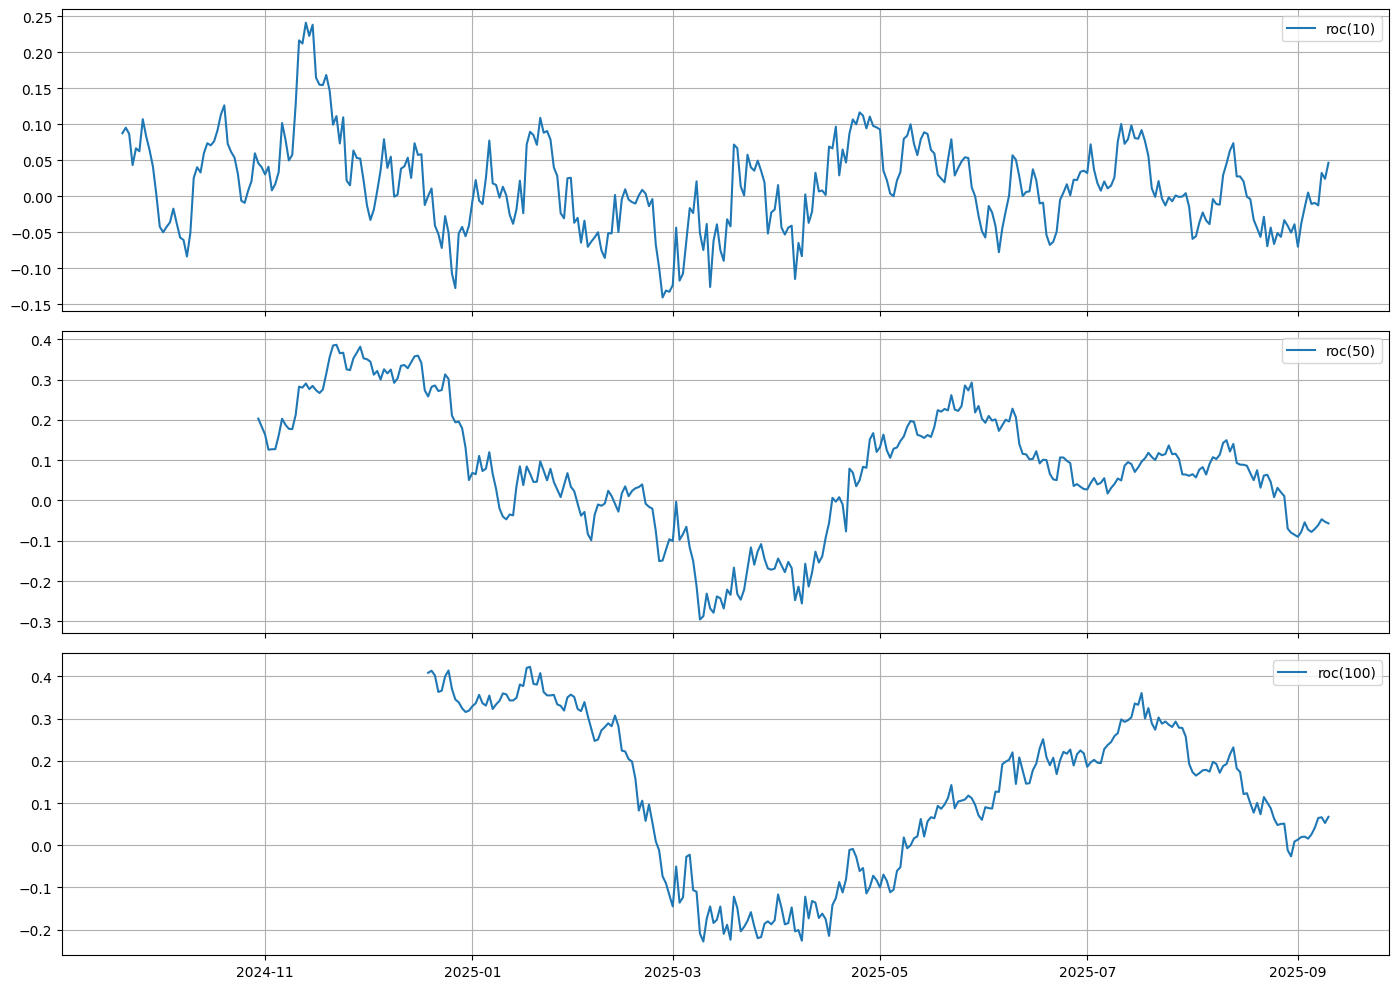

In [102]:
DF = pd.DataFrame( {'price' : price, })
DF = pd.concat([ DF, RocOscillator ], axis=1 )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ f'roc({short_n})' ]
middle = [ f'roc({medium_n})' ]
bottom = [ f'roc({long_n})' ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in middle:
  ax2.plot( DF[c], label=c )

for c in bottom:
  ax3.plot( DF[c], label=c )

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

### Relative Strength Index (RSI)

In [103]:
def rsiBase(metric, window, funcMA):
    diff = metric.diff()
    signs = np.sign(diff)
    isPositive = (signs + 1) / 2
    isNegative = (signs - 1).abs() / 2

    gain = isPositive * diff
    loss = isNegative * diff.abs()

    avgGain = funcMA(gain, window)
    avgLoss = funcMA(loss, window)

    rsi = avgGain / avgLoss
    rsi = 100 / (1 + rsi)
    return 100 - rsi

def rsiSma(metric, window):
    return rsiBase(metric, window, funcMA=simpleMA)

def rsiEma(metric, window):
    return rsiBase(metric, window, funcMA=expMA)

In [104]:
price = ohlc['Close']

window = 14

Rsi = pd.DataFrame({
    f'rsiEma({window})' : rsiEma(price, window),
})

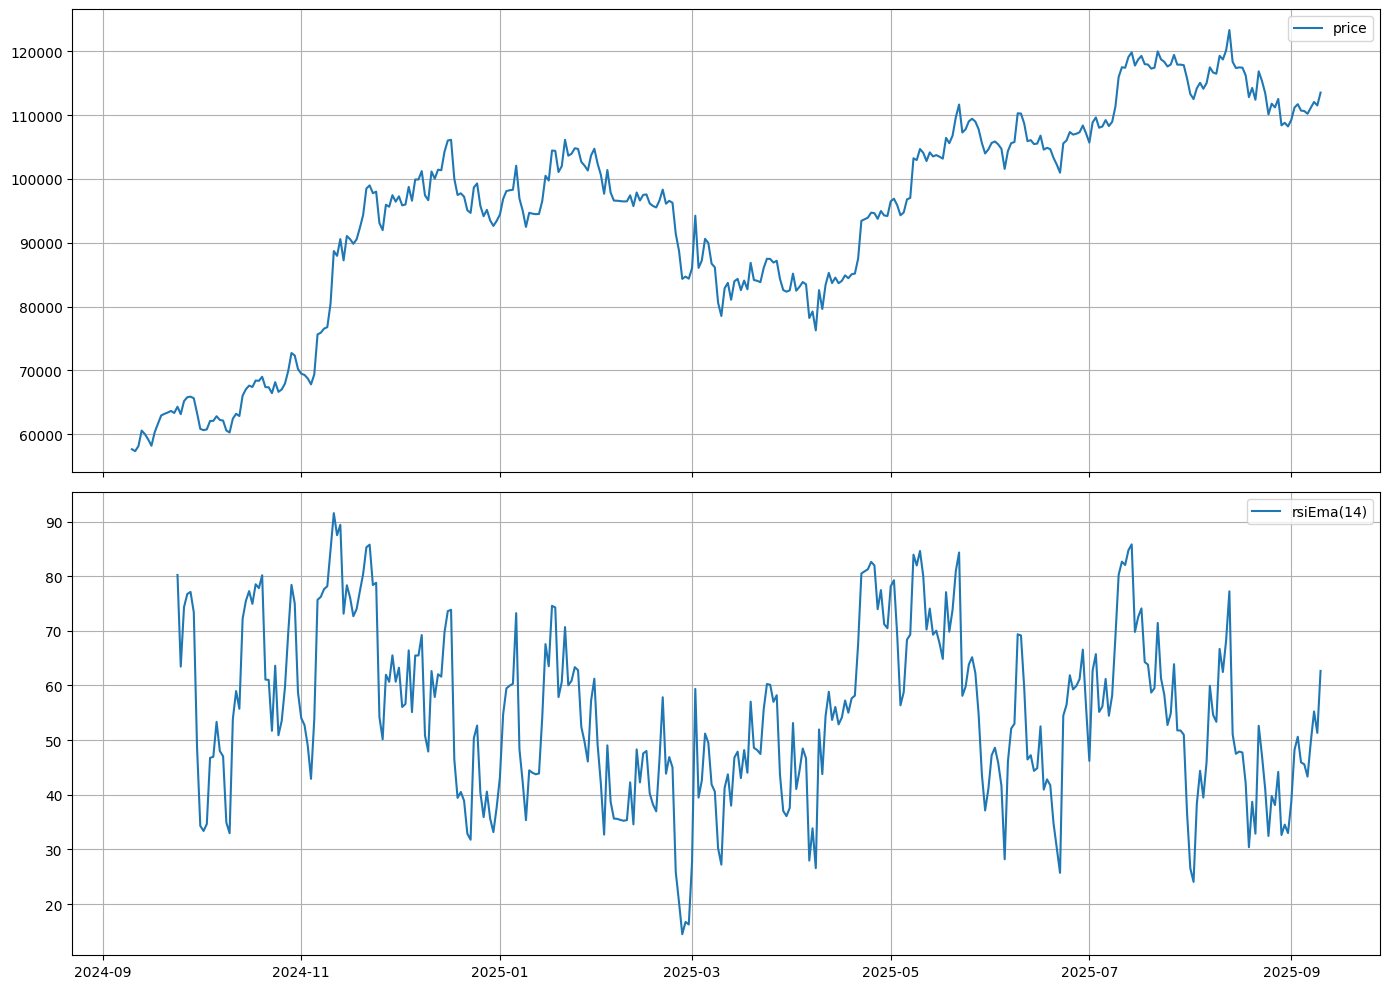

In [105]:
DF = pd.DataFrame({ 'price': price })
DF = pd.concat([ DF, Rsi ], axis=1 )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if c.startswith('price') ]
bottom = [ c for c in DF.columns if c.startswith('rsiEma') ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in bottom:
  ax2.plot( DF[c], label=c )

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

### Money Flow Index (MFI)

Tracks price movement, weighted by how much money is behind the movement.

For example:
- As prices rise with increasing volume, MFI might confirm that there's genuine buying pressure.
- But if prices are rising while the MFI fails to follow suit, that can be a warning that the rally is on shaky ground

In [106]:
def mfi(high, low, close, volume, window):
    tmp = mfiRatio(high, low, close, volume, window)
    tmp += 1
    return 100 - (100 / tmp)

def mfiRatio(high, low, close, volume, window):
    price = typicalPrice(high, low, close)
    mf = rawMoneyFlow(high, low, close, volume)

    diff = price.diff()
    signs = np.sign(diff)
    isPositive = (signs + 1) / 2
    isNegative = (signs - 1).abs() / 2

    mf_positive = mf * isPositive
    mf_negative = mf * isNegative

    ratio = mf_positive.rolling(window).sum()
    ratio /= mf_negative.rolling(window).sum()
    return ratio

def rawMoneyFlow(high, low, close, volume):
    return typicalPrice(high, low, close) * volume

def typicalPrice(high, low, close):
    return (high + low + close) / 3

In [107]:
window = 14

high    = ohlc['High']
low     = ohlc['Low']
close   = ohlc['Close']
volume  = ohlc['Volume']

Mfi = pd.DataFrame({
    f'mfi({window})' : mfi(high, low, close, volume, window), })


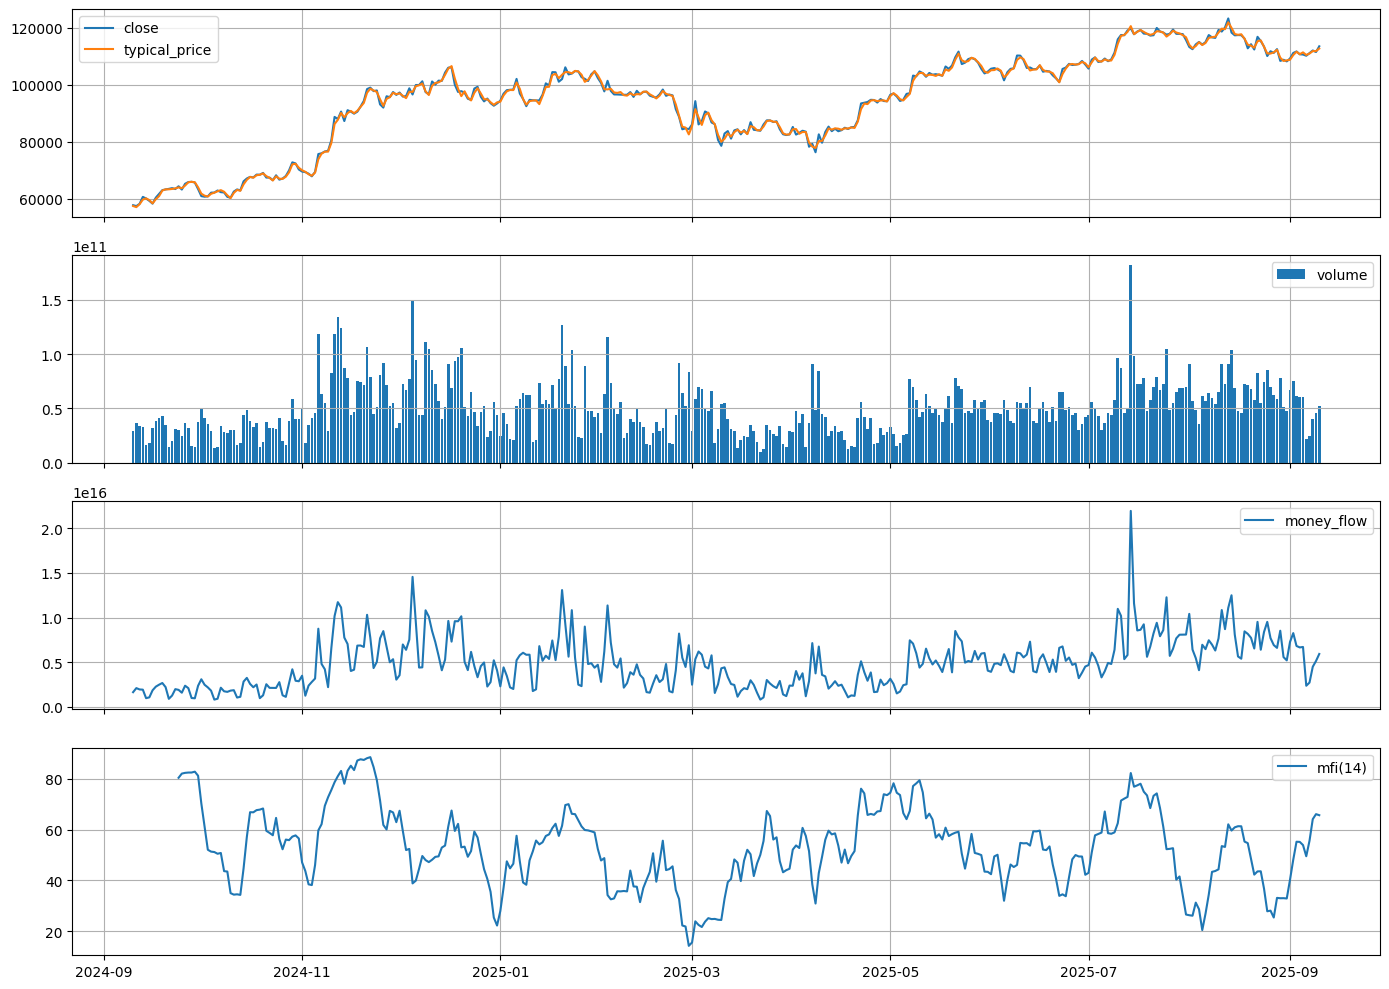

In [108]:
DF = pd.DataFrame({
    'close'          : close,
    'volume'         : volume,
    'typical_price'  : typicalPrice(high, low, close),
    'money_flow'     : rawMoneyFlow(high, low, close, volume),
})
DF = pd.concat([ DF, Mfi ], axis=1 )


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

top1   = [ c for c in DF.columns if c.startswith(('close', 'typical_price')) ]
top2   = [ 'volume' ]
middle = [ c for c in DF.columns if c.startswith('money_flow') ]
bottom = [ c for c in DF.columns if c.startswith('mfi') ]

for c in top1:
  ax1.plot( DF[c], label=c )

for c in top2:
  ax2.bar(DF.index, DF[c], label=c)

for c in middle:
  ax3.plot( DF[c], label=c )

for c in bottom:
  ax4.plot( DF[c], label=c )

for ax in [ax1, ax2, ax3, ax4]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

### Volatility Features


In [109]:
def atr(high, low, close, window=14):
    """Average True Range - measures volatility"""
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def realized_volatility(close, window=14):
    """Realized volatility (annualized)"""
    returns = close.pct_change()
    return returns.rolling(window).std() * np.sqrt(252)

high  = ohlc['High']
low   = ohlc['Low']
close = ohlc['Close']

window_vol = 14

atr_series   = atr(high, low, close, window_vol)
realized_vol = realized_volatility(close, window_vol)
vol_ratio    = realized_vol / realized_vol.rolling(60).mean()

Volatility = pd.DataFrame({
    f'atr({window_vol})': atr_series,
    f'realized_vol({window_vol})': realized_vol,
    'vol_ratio': vol_ratio,
})


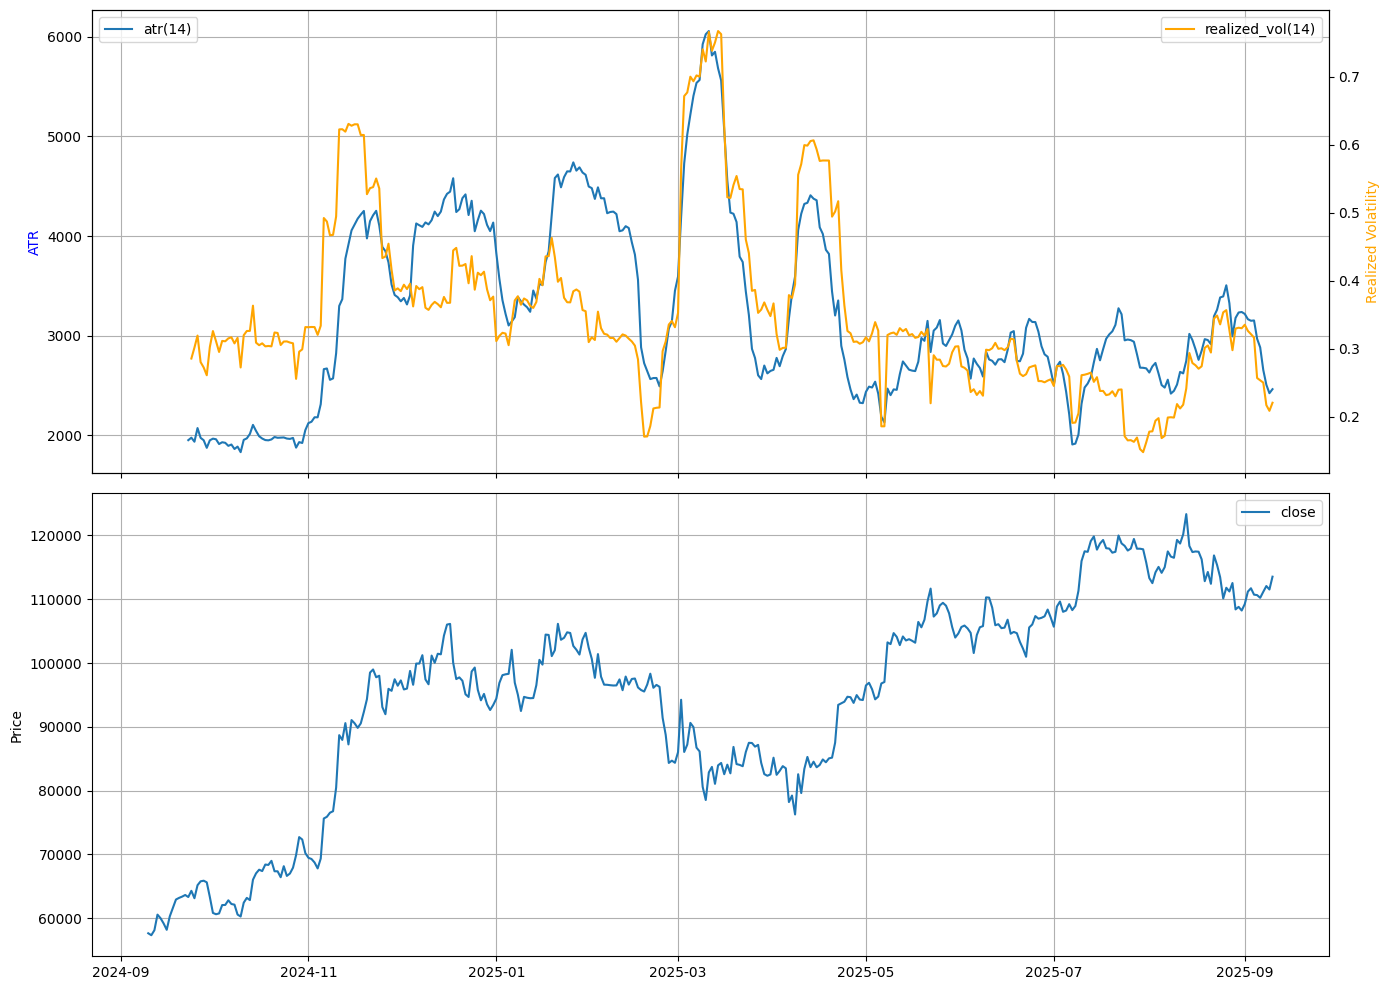

In [110]:
DF = pd.DataFrame({
    'close': close,
    f'atr({window_vol})': atr_series,
    f'realized_vol({window_vol})': realized_vol,
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top subplot: atr and realized_vol
ax1.plot(DF[f'atr({window_vol})'], label=f'atr({window_vol})')
ax1_twin = ax1.twinx()
ax1_twin.plot(DF[f'realized_vol({window_vol})'], label=f'realized_vol({window_vol})', color='orange')
ax1.set_ylabel('ATR', color='blue')
ax1_twin.set_ylabel('Realized Volatility', color='orange')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(True)

# Bottom subplot: close price
ax2.plot(DF['close'], label='close')
ax2.set_ylabel('Price')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### Volume Features


In [111]:
def obv(close, volume):
    """On-Balance Volume - cumulative volume indicator"""
    price_change = close.diff()
    obv_series = (volume * np.sign(price_change)).fillna(0).cumsum()
    return obv_series

def vwap(high, low, close, volume, window=20):
    """Volume-Weighted Average Price"""
    typical_price = (high + low + close) / 3
    vwap_series = (typical_price * volume).rolling(window).sum() / volume.rolling(window).sum()
    return vwap_series

high   = ohlc['High']
low    = ohlc['Low']
close  = ohlc['Close']
volume = ohlc['Volume']

window_vol_feat = 20

obv_series = obv(close, volume)
vwap_series = vwap(high, low, close, volume, window_vol_feat)

# Volume ratio (current vs average)
volume_ratio = volume / volume.rolling(window_vol_feat).mean()

# Price distance from VWAP (normalized)
price_vs_vwap = (close - vwap_series) / vwap_series

VolumeFeatures = pd.DataFrame({
    'obv': obv_series,
    f'obv_ma({window_vol_feat})': obv_series.rolling(window_vol_feat).mean(),
    f'vwap({window_vol_feat})': vwap_series,
    'price_vs_vwap': price_vs_vwap,
    'volume_ratio': volume_ratio,
})


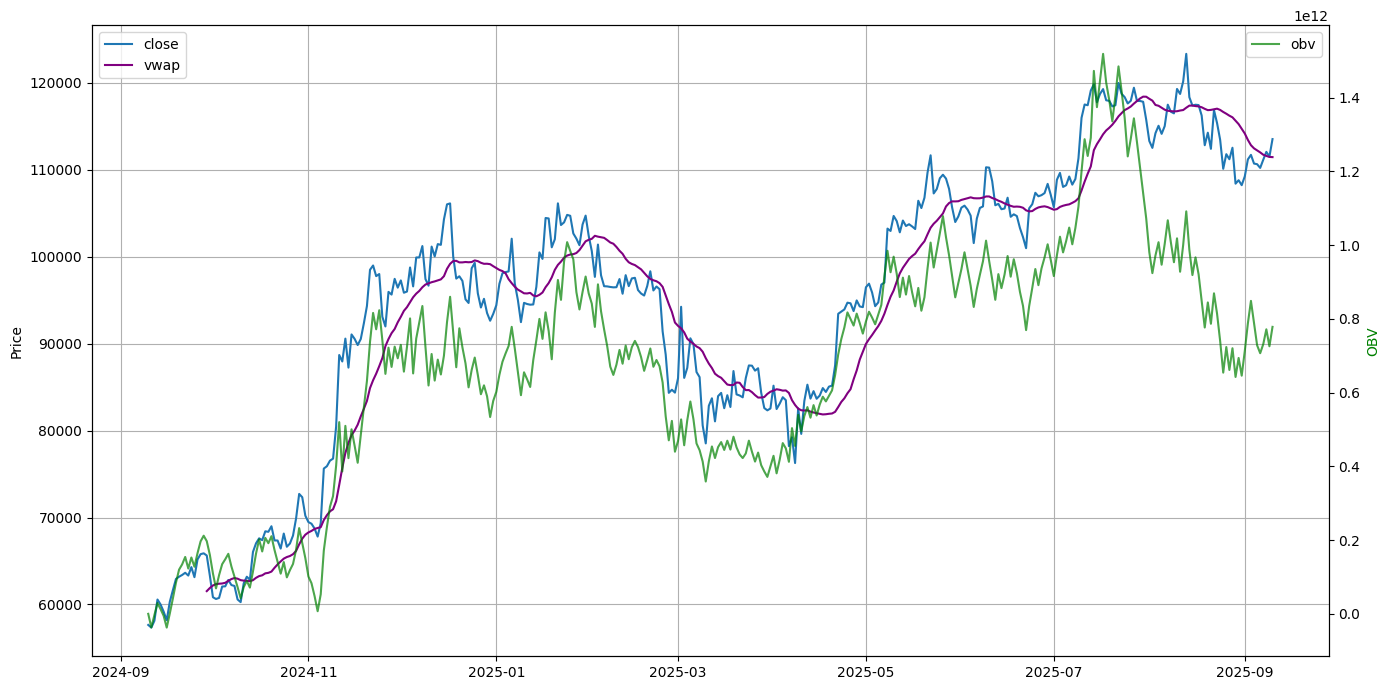

In [112]:
DF = pd.DataFrame({
    'close': close,
    'obv': obv_series,
    'vwap': vwap_series,
})

fig, ax1 = plt.subplots(1, 1, figsize=(14, 7))

# Plot close and vwap on the same y-axis (price scale)
ax1.plot(DF['close'], label='close')
ax1.plot(DF['vwap'], label='vwap', color='purple')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.grid(True)

# OBV on twin y-axis
ax1_twin = ax1.twinx()
ax1_twin.plot(DF['obv'], label='obv', color='green', alpha=0.7)
ax1_twin.set_ylabel('OBV', color='green')
ax1_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Lag Features (Returns & Momentum)


In [113]:
# Lagged returns
close = ohlc['Close']

return_1d  = close.pct_change(1)
return_3d  = close.pct_change(3)
return_5d  = close.pct_change(5)
return_10d = close.pct_change(10)

# Momentum (price change over period)
momentum_5d  = close / close.shift(5) - 1
momentum_10d = close / close.shift(10) - 1
momentum_20d = close / close.shift(20) - 1

LagFeatures = pd.DataFrame({
    'return_1d'    : return_1d,
    'return_3d'    : return_3d,
    'return_5d'    : return_5d,
    'return_10d'   : return_10d,
    'momentum_5d'  : momentum_5d,
    'momentum_10d' : momentum_10d,
    'momentum_20d' : momentum_20d,
})


### Price Position Features


In [114]:
def price_position(close, window=20):
    """Price position in recent range (0 = at low, 1 = at high)"""
    high = close.rolling(window).max()
    low = close.rolling(window).min()
    return (close - low) / (high - low)

close = ohlc['Close']
window_pos = 20

price_pos = price_position(close, window_pos)
high_20 = close.rolling(window_pos).max()
low_20 = close.rolling(window_pos).min()

# Distance from recent high/low (as percentage)
dist_from_high = (close - high_20) / high_20
dist_from_low = (close - low_20) / low_20

PricePosition = pd.DataFrame({
    f'price_position({window_pos})': price_pos,
    f'dist_from_high({window_pos})': dist_from_high,
    f'dist_from_low({window_pos})': dist_from_low,
})


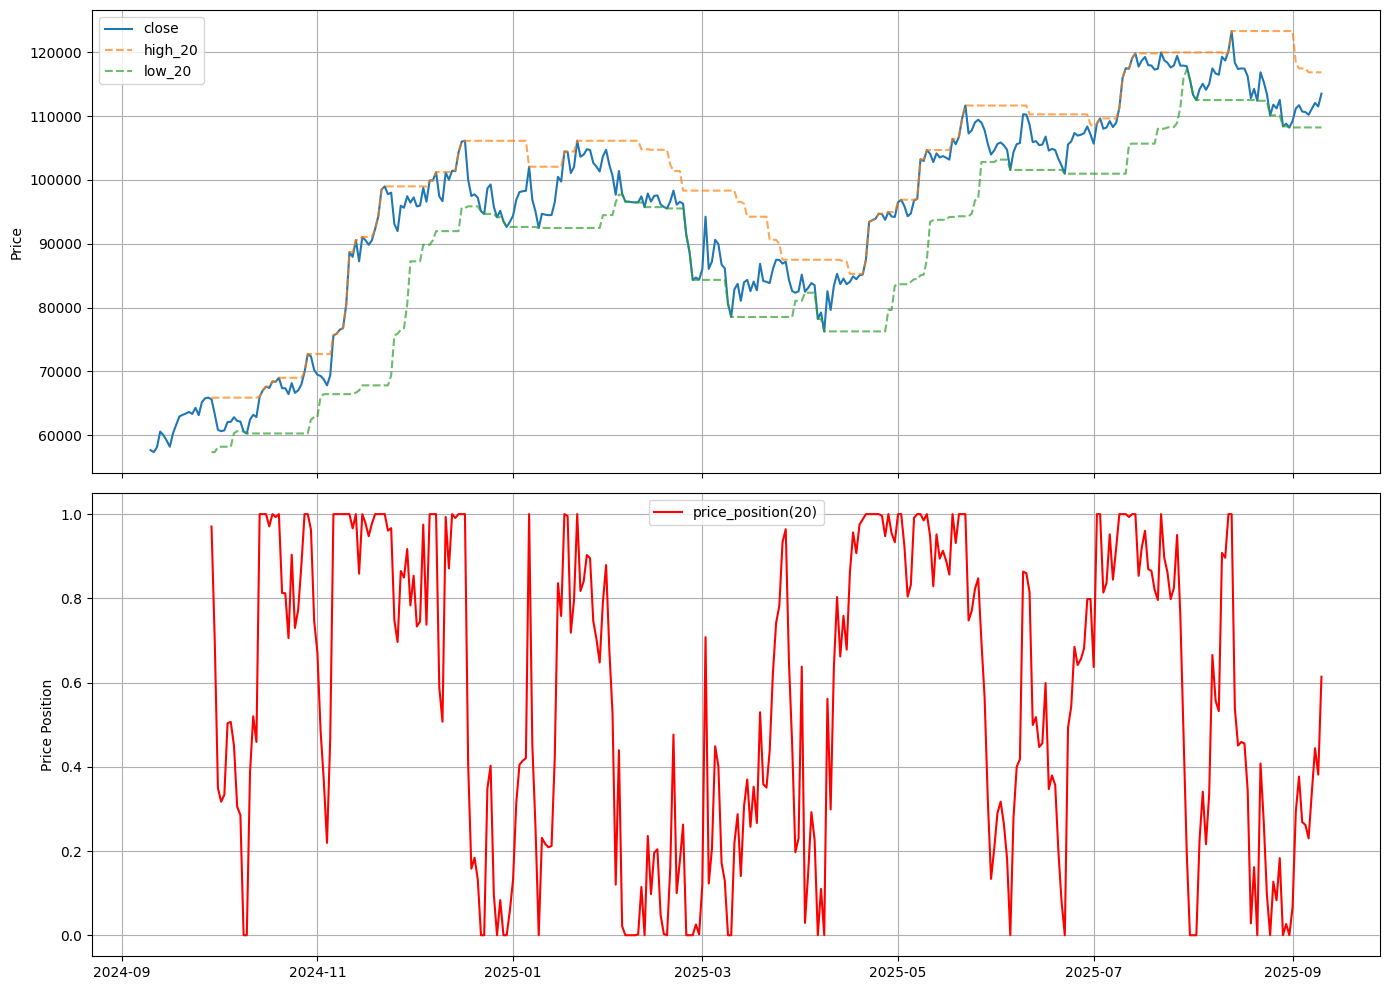

In [115]:
DF = pd.DataFrame({
    'close': close,
    f'price_position({window_pos})': price_pos,
    'high_20': high_20,
    'low_20': low_20,
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top subplot: close, high_20, low_20
ax1.plot(DF['close'], label='close')
ax1.plot(DF['high_20'], label='high_20', linestyle='--', alpha=0.7)
ax1.plot(DF['low_20'], label='low_20', linestyle='--', alpha=0.7)
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# Bottom subplot: price_position
ax2.plot(DF[f'price_position({window_pos})'], label=f'price_position({window_pos})', color='red')
ax2.set_ylabel('Price Position')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Features


In [116]:
Features = pd.concat([
    MA,
    Crossover,
    Bollinger,
    Macd,
    Rsi,
    Mfi,
    Volatility,      # NEW: Volatility features (ATR, realized vol, vol ratio)
    VolumeFeatures,  # NEW: Volume features (OBV, VWAP, volume ratios)
    LagFeatures,     # NEW: Lag features (returns, momentum)
    PricePosition,   # NEW: Price position features (distance from highs/lows)
], axis=1 )

print(len(Features))
print(f"Total features: {len(Features.columns)}")
Features.tail()


366
Total features: 25


,ema(30),"x(sma(15),sma(50))","bollUpper(20,2)","bollLower(20,2)","macdDistance(12, 26, 9)",rsiEma(14),mfi(14),atr(14),realized_vol(14),vol_ratio,...,return_1d,return_3d,return_5d,return_10d,momentum_5d,momentum_10d,momentum_20d,price_position(20),dist_from_high(20),dist_from_low(20)
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-06,112719.860474,-1.0,116790.061701,106850.665299,31.246031,43.325287,49.517919,2883.630714,0.253541,1.015484,...,-0.003852,-0.013413,0.008916,-0.008967,0.008916,-0.008967,-0.061543,0.230161,-0.056894,0.018367
2025-09-07,112619.715928,-1.0,116080.579405,107051.678595,123.447427,49.689109,55.602814,2656.838571,0.250078,0.998609,...,0.008555,0.004010,-0.000296,-0.012237,-0.000296,-0.012237,-0.043738,0.339329,-0.048826,0.027079
2025-09-08,112584.342642,-1.0,116010.442618,107045.840382,245.823697,55.246898,64.088129,2508.628571,0.216980,0.868987,...,0.008130,0.012837,0.003117,0.033766,0.003117,0.033766,-0.006734,0.443968,-0.041093,0.035429
2025-09-09,112516.356020,-1.0,115683.202514,107098.661486,287.940804,51.331334,66.056176,2423.897143,0.208602,0.838408,...,-0.004826,0.011847,0.007288,0.025021,0.007288,0.025021,-0.024014,0.381347,-0.045720,0.030432
2025-09-10,112582.314986,-1.0,115824.018564,107069.814436,439.563315,62.666593,65.646769,2464.250000,0.220488,0.888711,...,0.018006,0.021329,0.026098,0.048985,0.026098,0.048985,0.009960,0.613845,-0.028538,0.048985


In [117]:
Features = Features.dropna()
print(f"After dropping NaN: {len(Features)} samples")
print(f"Total features: {len(Features.columns)}")
print(f"\nFeature categories:")
print(f"  - Original features: {len(MA.columns) + len(Crossover.columns) + len(Bollinger.columns) + len(Macd.columns) + len(Rsi.columns) + len(Mfi.columns)}")
print(f"  - Volatility features: {len(Volatility.columns)}")
print(f"  - Volume features: {len(VolumeFeatures.columns)}")
print(f"  - Lag features: {len(LagFeatures.columns)}")
print(f"  - Price position features: {len(PricePosition.columns)}")

After dropping NaN: 293 samples
Total features: 25

Feature categories:
  - Original features: 7
  - Volatility features: 3
  - Volume features: 5
  - Lag features: 7
  - Price position features: 3


## Target

In [118]:
price  = ohlc['Close']

def create_3class_target(price, up_threshold=0.01, down_threshold=-0.01):
    """
    Create 3-class target that filters out noise.
      0: Down (<= -1% decrease)
      1: Stationary (between -1% and +1%)
      2: Up (>= +1% increase)
    """
    returns = price.pct_change().shift(-1)

    target = pd.Series(1, index=price.index, dtype=int)
    target[returns >= up_threshold] = 2    # Up (>= 1%)
    target[returns <= down_threshold] = 0  # Down (<= -1%)


    target = target.iloc[:-1] # remove last row (can't predict it)

    return target

Target = create_3class_target(price, up_threshold=0.01, down_threshold=-0.01)
Target = Target.to_frame( 'Target' )


## Serialize

In [119]:
index = Target.index.intersection( Features.index )

Features.loc[ index ].to_parquet( root / '2. features.parquet')
Target.loc[ index ].to_parquet( root / '2. target.parquet')